In [2]:
from manim import *
import jupyter_capture_output

video_scene = f" -v WARNING --disable_caching cf_Scene"
image_scene = f" -v WARNING --disable_caching -r {2*427},{2*240}  -s cf_Scene"

Manim Community v0.17.3

Jupyter Capture Output v0.0.11


In [171]:
main_color = WHITE


class IncomingSigmal(Mobject):
    def __init__(self, position, height, width, **kwargs):
        super().__init__(**kwargs)

        rectangle = Rectangle(height = height, width = width, stroke_width = 2, color = main_color).move_to(position)
        separator = Line(start = position - np.array([width/2, 0, 0]), end = position + np.array([width/2, 0, 0]), stroke_width = 1, color = main_color)
        self.add(rectangle, separator)

        # number plane for the untransformed signal
        self.signal_npla = NumberPlane(
            x_range = [-1, 1, 0.1], y_range = [-2, 4, 1], x_length = 9.5/10*width, y_length = 9/10*height/2,
            x_axis_config = {"stroke_opacity": 0.215}, y_axis_config = {"stroke_opacity": 0.125}, background_line_style = {"stroke_opacity": 0.125}
        ).move_to(position + np.array([0, height/4, 0]))
        
        # coordinate system for the FT signal
        self.ft_signal_nl = NumberLine(
            x_range = [128, 512, 32], length = 9/10*width, include_numbers = True, font_size = 16,
        ).move_to(position - np.array([0, height/4 + height/8, 0]))

        self.add(self.signal_npla)
        self.add(self.ft_signal_nl)


    # return untransformed signal
    def get_signal(self, omega_xyc):
        omega_x = omega_xyc[0]
        omega_y = omega_xyc[1]
        omega_c = omega_xyc[2]

        # superposition of the 3 waves
        correction_factor = 8
        def signal_wave(t):
            return (np.cos(omega_x * t / correction_factor) + np.cos(omega_y * t / correction_factor) + np.cos(omega_c * t / correction_factor)) * np.exp(-PI*t**2)
        
        return self.signal_npla.plot(signal_wave, x_range = [-1, 1], stroke_width = 2, stroke_color = main_color)


    # returns transformed signal
    def get_ft_signal(self, omega_xyc):
        omega_x = omega_xyc[0]
        omega_y = omega_xyc[1]
        omega_c = omega_xyc[2]

        ft_signal_y_shift = np.array([0, 0.9, 0])

        omega_x_line = Line(start = self.ft_signal_nl.n2p(omega_x), end = self.ft_signal_nl.n2p(omega_x) + ft_signal_y_shift, color = RED)
        omega_y_line = Line(start = self.ft_signal_nl.n2p(omega_y), end = self.ft_signal_nl.n2p(omega_y) + ft_signal_y_shift, color = BLUE)
        omega_c_line = Line(start = self.ft_signal_nl.n2p(omega_c), end = self.ft_signal_nl.n2p(omega_c) + ft_signal_y_shift, color = GREY)
        return VGroup(omega_x_line, omega_y_line, omega_c_line)
        

class FTransformedImage(Mobject):
    def __init__(self, position, size, **kwargs):
        super().__init__(**kwargs)
        self.grid_center = position
        self.grid_sidelength = size
        self.grid_pixels = 128
        self.grid_node_dist = self.grid_sidelength / (self.grid_pixels + 1)

        # x-axis
        self.x_ax = NumberLine(
            x_range = [128, 256, 16], length = self.grid_sidelength, include_numbers = True, font_size = 16
            ).set_color(RED).move_to(position - np.array([0, self.grid_sidelength/2+0.5, 0]))

        # y-axis
        self.y_ax = NumberLine(
            x_range = [256, 384, 16], length = self.grid_sidelength, include_numbers = True, font_size = 16, rotation = PI/2, label_direction = LEFT
            ).set_color(BLUE).move_to(position - np.array([self.grid_sidelength/2+0.5, 0, 0]))

        # square with text
        square = Square(side_length = self.grid_sidelength, stroke_width = 2, stroke_color = main_color, **kwargs).move_to(np.array([self.x_ax.n2p(192)[0], self.y_ax.n2p(320)[1], 0]))
        square_text_head = Tex(r"Originales Bild", font_size = 32, color = main_color).next_to(square, 0.5*UP)
        self.add(self.x_ax, self.y_ax, square)


    # function to create a pixel for a given tupel of frequencies (omega_x, omega_y, omega_c)
    def get_pixel(self, omega_xyc):
        omega_x = omega_xyc[0]
        omega_y = omega_xyc[1]
        omega_c = omega_xyc[2]

        nl_node_dist = self.x_ax.n2p(1)[0] - self.x_ax.n2p(0)[0]
        node_position = np.array([self.x_ax.n2p(omega_x)[0] + self.grid_node_dist/2, self.y_ax.n2p(omega_y)[1] + self.grid_node_dist/2, 0])
        return Square(side_length = nl_node_dist, color = GREY, stroke_width = 1, fill_opacity = 1).move_to(node_position)
    

    # creates an object pointing towards the frequency tupel
    def get_pixel_arm(self, omega_xyc):
        omega_x = omega_xyc[0]
        omega_y = omega_xyc[1]
        omega_c = omega_xyc[2]

        x_circle = Circle(radius = 0.05, color = main_color).move_to(self.x_ax.n2p(omega_x+0.5))
        y_circle = Circle(radius = 0.05, color = main_color).move_to(self.y_ax.n2p(omega_y+0.5))
        return VGroup(x_circle, y_circle)

Output saved by creating file at animations/christmas_fourier/christmas_fourier.mp4.


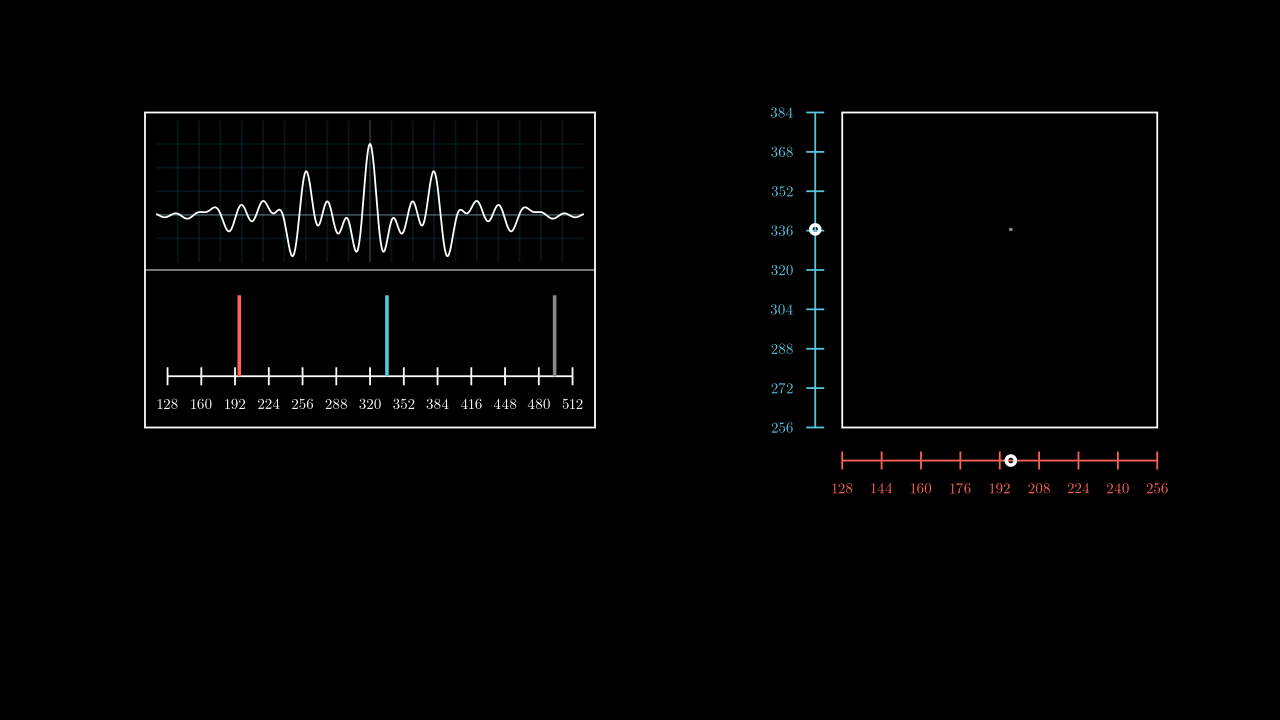

In [170]:
%%capture_video --path "animations/christmas_fourier/christmas_fourier.mp4"
%%manim -qm --fps 20 $video_scene


class cf_Scene(Scene):
    def construct(self):
        #self.camera.background_color = WHITE

        signal_omega_xyc = (196, 336, 495)


        image = FTransformedImage(position = np.array([4, 1, 0]), size = 3.5)
        self.add(image)

        sq = image.get_pixel(signal_omega_xyc)
        sq_arm = image.get_pixel_arm(signal_omega_xyc)
        self.add(sq, sq_arm)

        signal = IncomingSigmal(position = (-3, 1, 0), height = 3.5, width = 5)
        self.add(signal)

        signal_wave = signal.get_signal(signal_omega_xyc)
        self.add(signal_wave)

        signal_ft_signal = signal.get_ft_signal(signal_omega_xyc)
        self.add(signal_ft_signal)